# 1. Gender Classification Using Gated recurrent unit (GRU)

## 1.1 Necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import GRU, Dense, Activation, Flatten
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [3]:
y = df['classification'].astype("category").cat.codes.values # y labels into numbers
names = df['first_name'].apply(lambda x: x.lower()) # input names

## 1.3 Encoding Words

In [4]:
maxlen = 20
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
char_index = dict((c, i) for i, c in enumerate(vocab))

In [5]:
x = []
# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_encod_names(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


x = prepare_encod_names(names.values)

## 1.4 Split the data into test and train

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## 1.5 Building the GRU Model

In [83]:
model=keras.Sequential()
model.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1))) 
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()                                             # print the model

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 20, 32)            5952      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 1)             33        
_________________________________________________________________
flatten_20 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 21        
Total params: 6,006
Trainable params: 6,006
Non-trainable params: 0
_________________________________________________________________


## 1.6 Fitting the data into model

In [84]:
history=model.fit(x_train, y_train , epochs=10, batch_size=128, validation_data=(x_test,y_test))
scores = model.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
630/630 [==============================] - 10s 14ms/step - loss: 0.3196 - accuracy: 0.8492 - val_loss: 0.1719 - val_accuracy: 0.9311
Epoch 2/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1673 - accuracy: 0.9347 - val_loss: 0.1584 - val_accuracy: 0.9382
Epoch 3/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1446 - accuracy: 0.9440 - val_loss: 0.1406 - val_accuracy: 0.9462
Epoch 4/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1303 - accuracy: 0.9507 - val_loss: 0.1361 - val_accuracy: 0.9493
Epoch 5/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1217 - accuracy: 0.9536 - val_loss: 0.1358 - val_accuracy: 0.9504
Epoch 6/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1128 - accuracy: 0.9568 - val_loss: 0.1320 - val_accuracy: 0.9500
Epoch 7/10
630/630 [==============================] - 8s 13ms/step - loss: 0.1068 - accuracy: 0.9597 - val_loss: 0.1363 - val_accuracy: 0.948

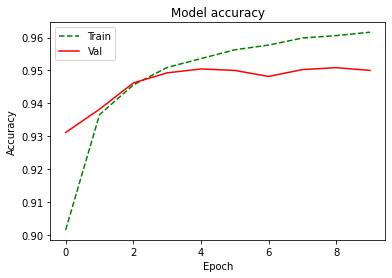

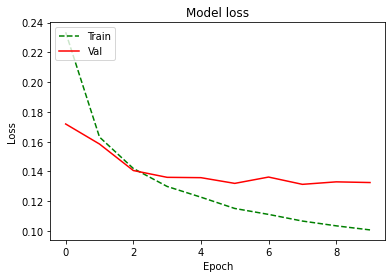

In [85]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], 'g--')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], 'g--')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

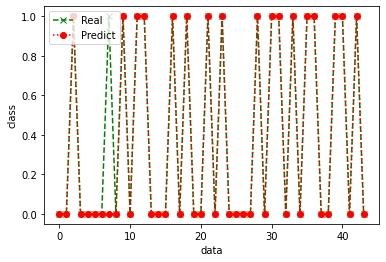

In [86]:
y_pred =(model.predict(x_test) > 0.5).astype("int32")
plt.figure(2)
plt.plot(y_test[6:50], 'g--x')
plt.plot(y_pred[6:50], 'r:o')
plt.ylabel('class')
plt.xlabel('data')
plt.legend(['Real', 'Predict'], loc='upper left')
plt.show()